In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

nb_epoch = 50
batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ridiculously_small'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (4, 4), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (504, 56, 56)   out (504, 12, 12)
in (63, 56, 56)   out (63, 12, 12)


In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(504, 56, 56, 1) (504, 12, 12, 1)
(63, 56, 56, 1) (63, 12, 12, 1)


In [7]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

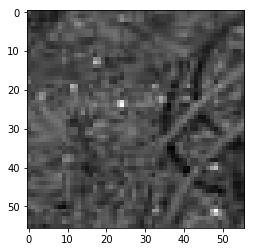

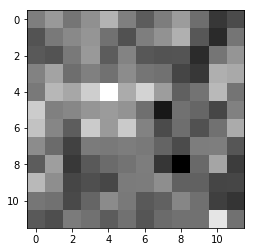

In [8]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [16]:
my_adadelta = keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95)

In [17]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened)


x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer=my_adadelta, loss="binary_crossentropy")
brief_ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1180

In [11]:
from keras.callbacks import Callback

# taken from https://github.com/keras-team/keras/issues/7874#issuecomment-329347949

class LRPrintCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(K.eval(lr_with_decay))
        print(K.eval(lr))
        print(K.eval(decay))
        
lr_printer = LRPrintCallback()

In [12]:
model_version_previous = '0.0.0.3.4_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12_lr0.001_200moreepochs'
brief_ae_previous = load_model(base_dir + '/brief_ae_' + model_version_previous + '.h5')

In [13]:
brief_ae_previous.get_layer(index=7).get_weights()[0].shape

(512, 1152)

In [15]:
for i in range(7, len(brief_ae.layers)):
    print(brief_ae_previous.get_layer(index=i))
    brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [18]:
model_version = '0.0.1.0.0_whole_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12_lr0.1'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0]#,
                #callbacks=[lr_printer]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/50
504/504 [==============================] - 16s 31ms/step - loss: 0.6441 - val_loss: 0.6184
Epoch 2/50
504/504 [==============================] - 16s 31ms/step - loss: 0.6073 - val_loss: 0.6179
Epoch 3/50
504/504 [==============================] - 16s 31ms/step - loss: 0.6019 - val_loss: 0.6129
Epoch 4/50
504/504 [==============================] - 16s 31ms/step - loss: 0.5990 - val_loss: 0.6084
Epoch 5/50
504/504 [==============================] - 16s 31ms/step - loss: 0.5969 - val_loss: 0.6102
Epoch 6/50
504/504 [==============================] - 16s 31ms/step - loss: 0.5952 - val_loss: 0.6078
Epoch 7/50
504/504 [==============================] - 16s 31ms/step - loss: 0.5941 - val_loss: 0.6069
Epoch 8/50
504/504 [==============================] - 16s 31ms/step - loss: 0.5930 - val_loss: 0.6077
Epoch 9/50
504/504 [==============================] - 16s 31ms/step - loss: 0.5922 - val_loss: 0.6048
Epoch 10/50
504/504 [==============================] - 16s 31ms/step - loss: 0.591

predictions: 


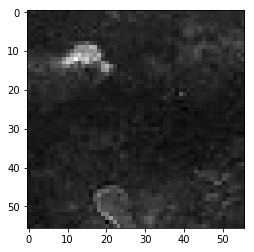

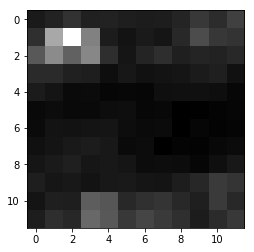

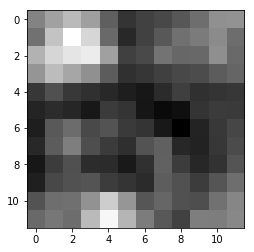

5.58236975222826

 next


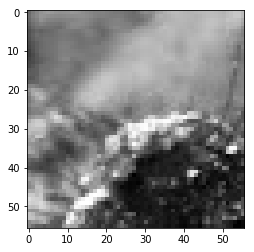

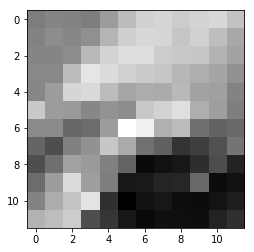

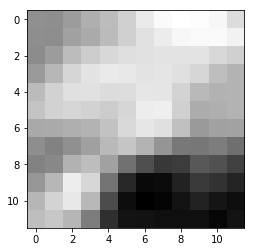

16.941949501633644

 next


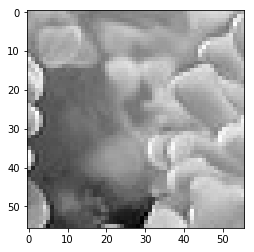

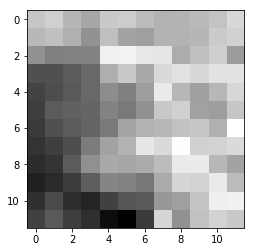

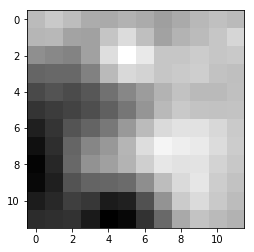

14.115227032452822

 next


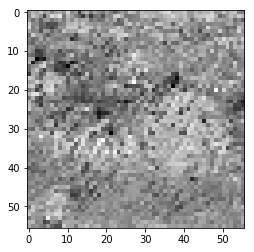

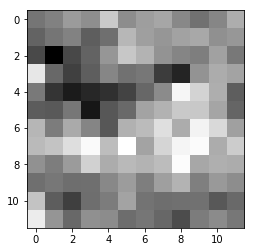

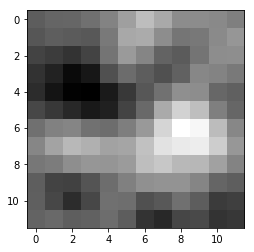

13.419621158391237

 next


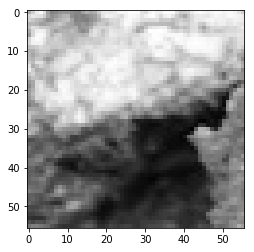

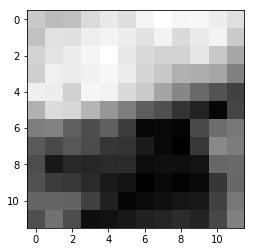

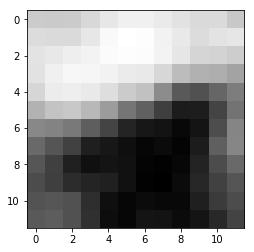

19.318735264241695

 next


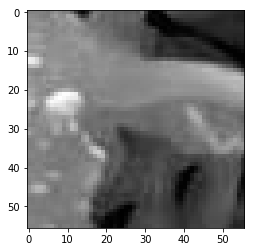

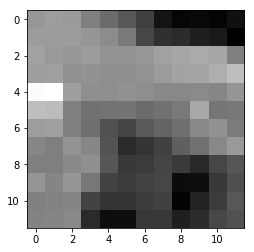

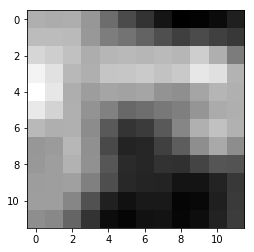

15.897271558642387

 next


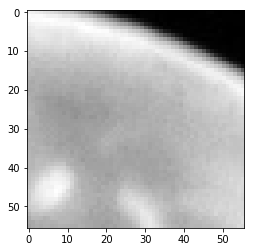

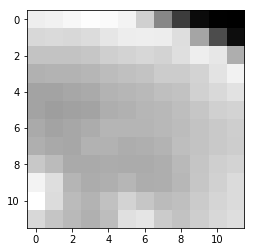

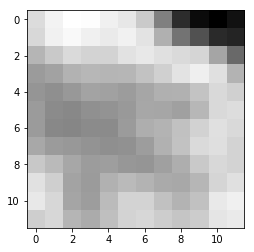

15.342661868780851

 next


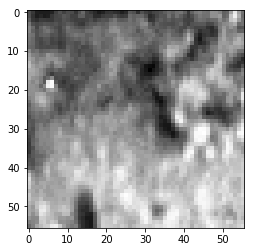

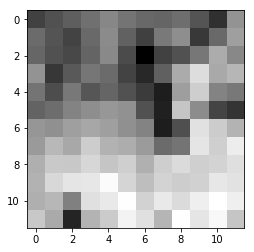

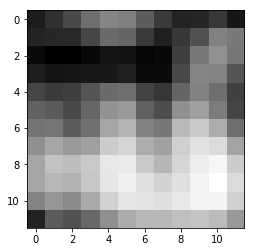

14.069816619157791

 next


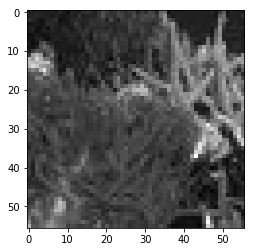

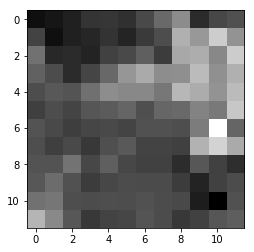

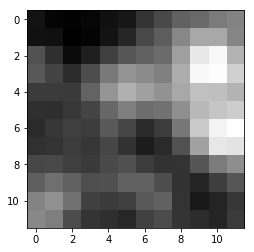

9.962679706513882

 next


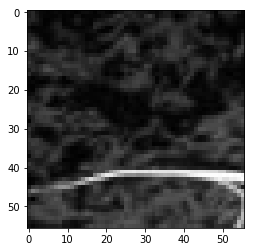

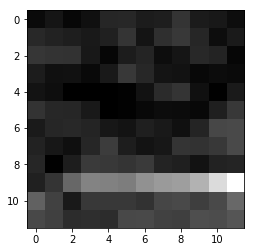

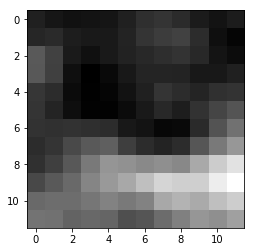

17.912430725991726

 next


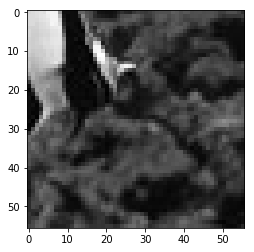

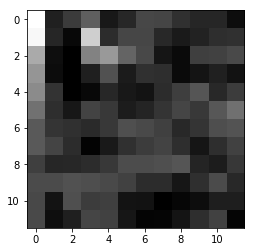

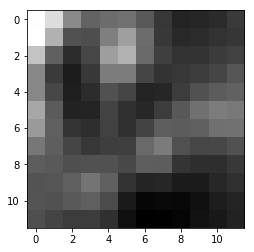

25.221148543059826

 next


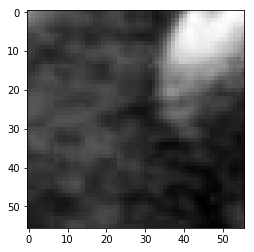

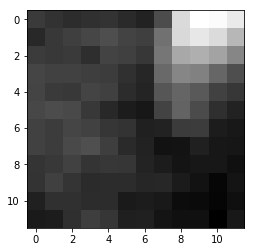

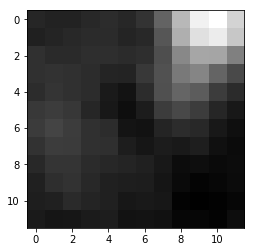

8.285898081958294

 next


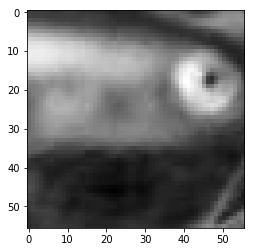

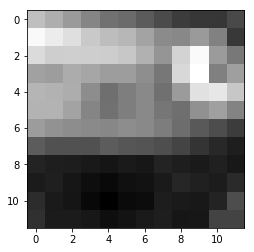

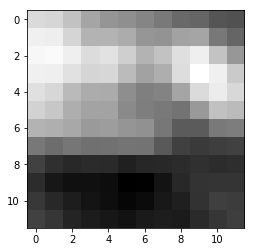

14.358768314123154

 next


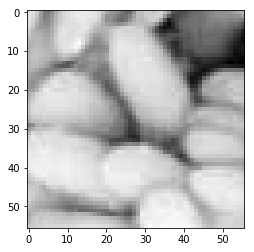

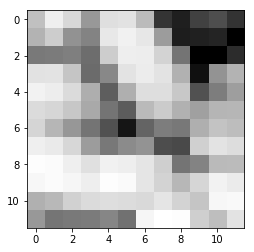

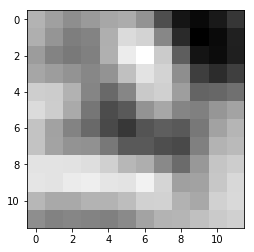

13.596498817205429

 next


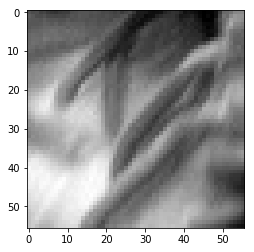

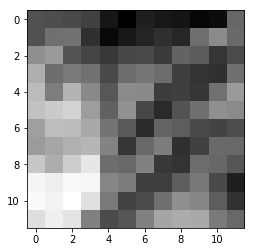

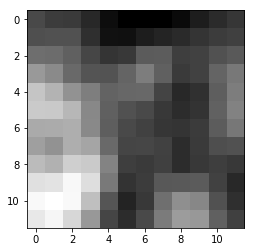

12.150757145136595

 next


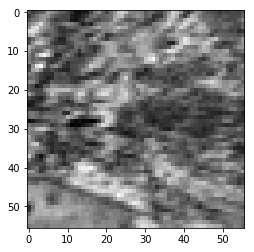

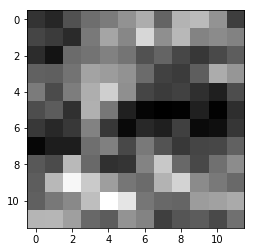

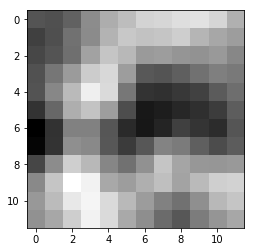

8.908442426472902

 next


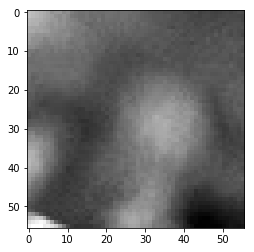

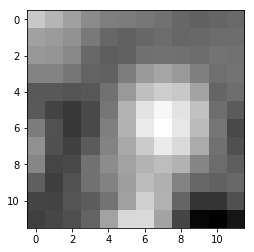

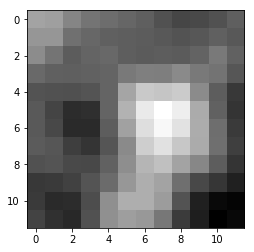

6.468334486708045

 next


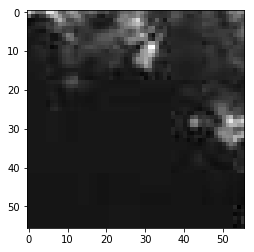

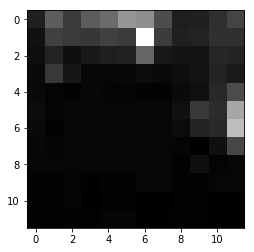

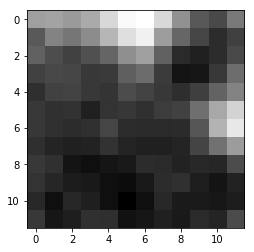

6.181161096319556

 next


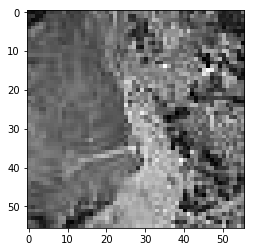

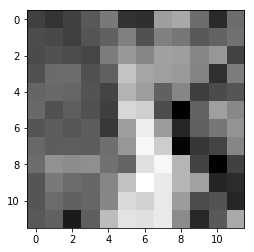

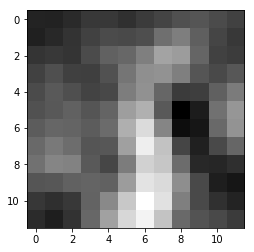

15.206989198923111

 next


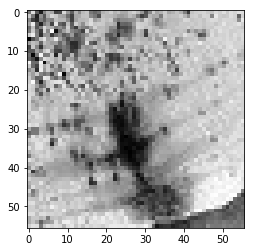

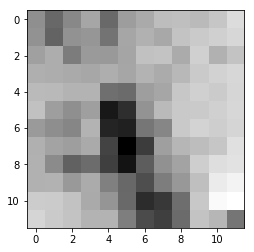

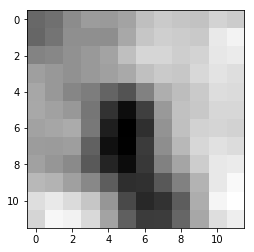

20.71125414222479

 next


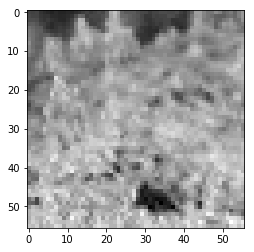

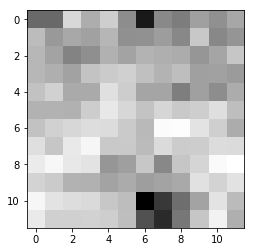

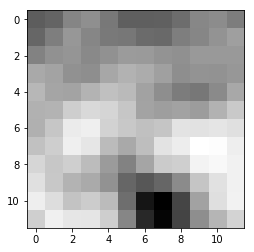

9.265719205141068

 next


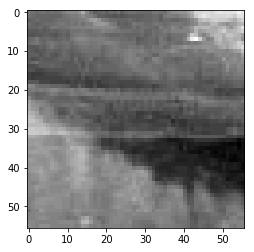

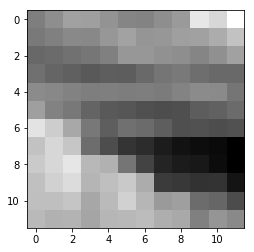

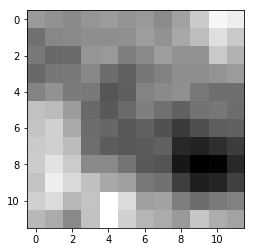

5.032658949494362

 next


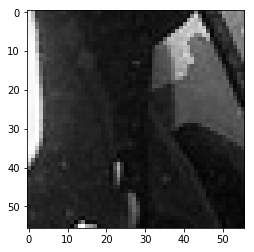

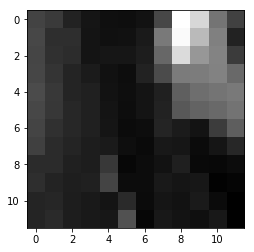

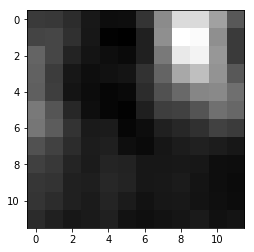

11.893756035715342

 next


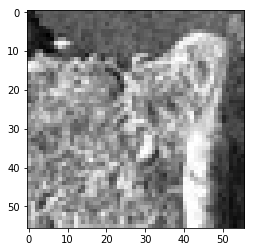

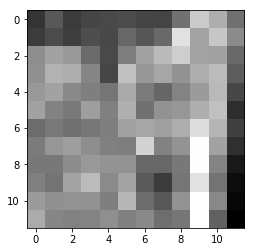

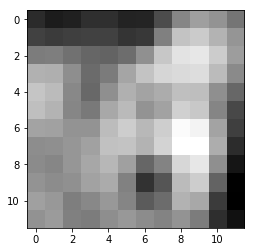

26.749776117503643

 next


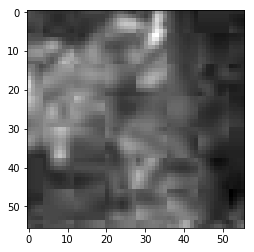

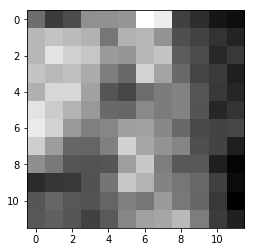

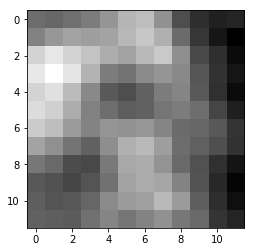

6.634021745994687

 next


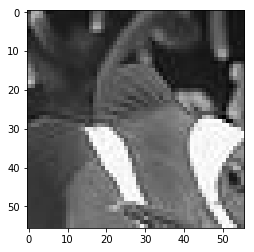

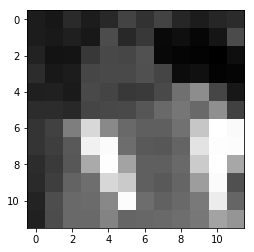

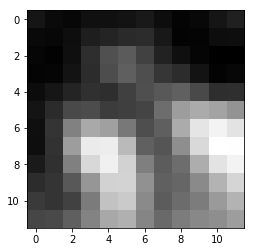

25.183401368558407

 next


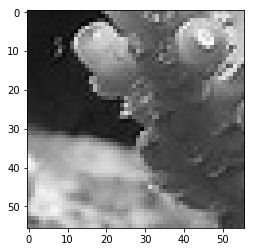

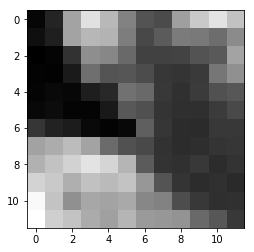

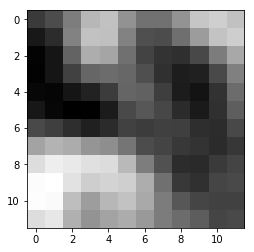

17.708246782422066

 next


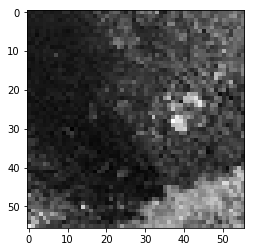

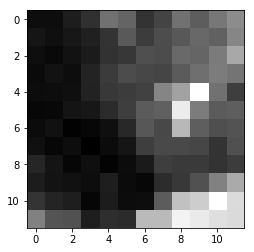

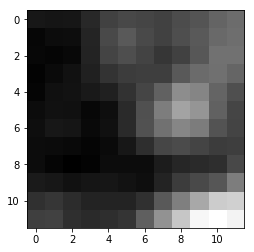

10.854761637747288

 next


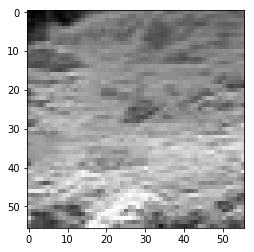

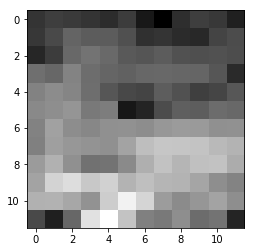

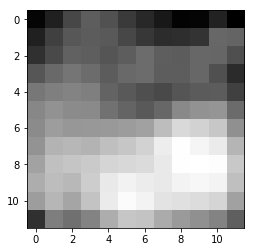

8.260184861719608

 next


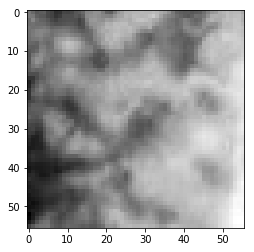

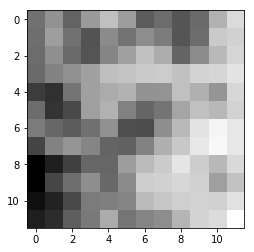

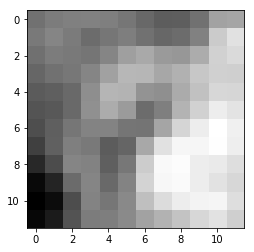

11.099382061511278

 next


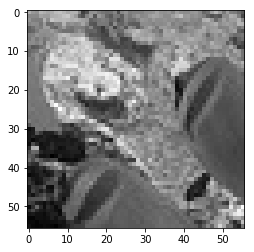

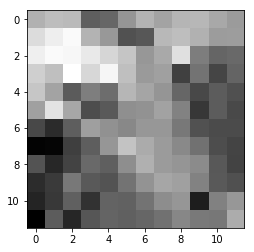

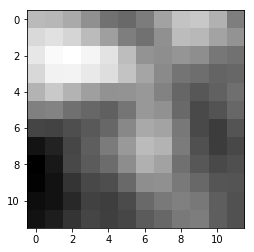

14.103157930076122

 next


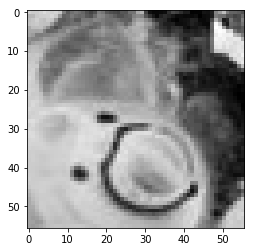

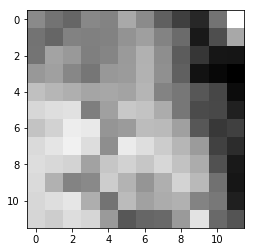

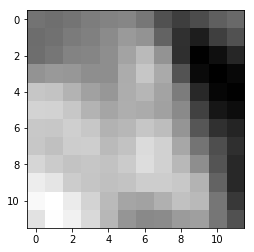

23.265908360481262

 next


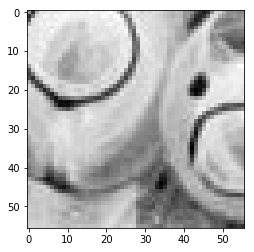

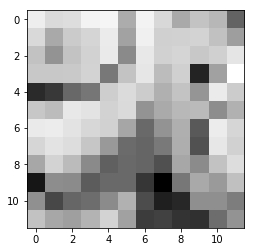

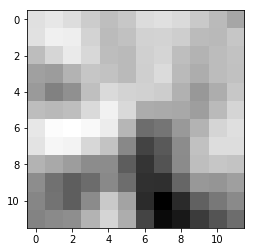

20.28225716203451

 next


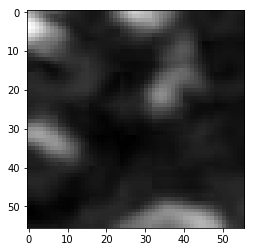

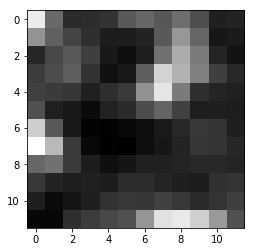

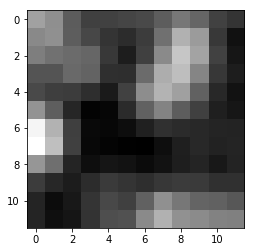

9.347791951149702

 next


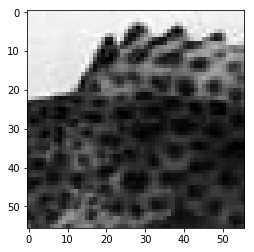

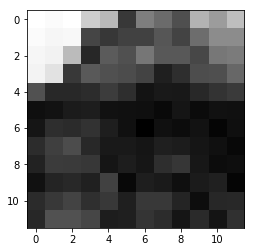

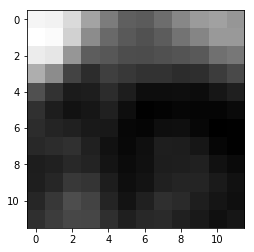

20.30648086220026

 next


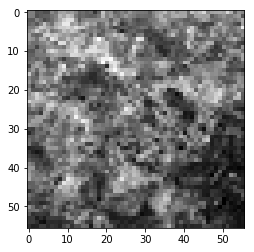

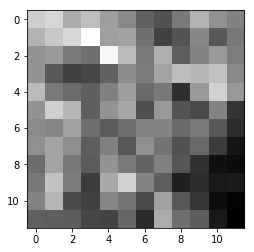

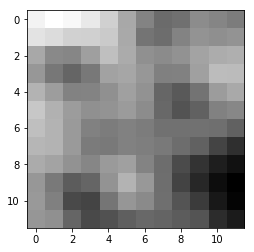

15.150682870298624

 next


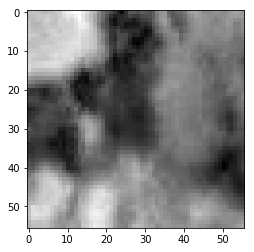

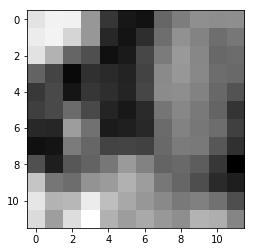

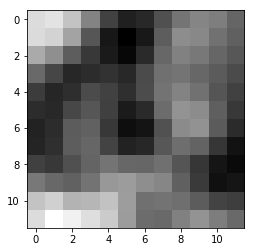

9.913868475705385

 next


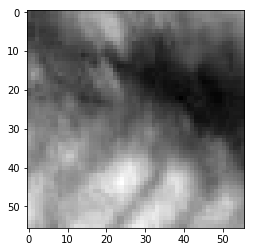

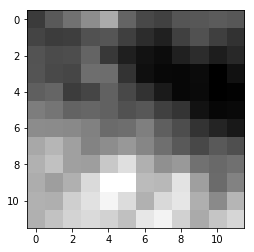

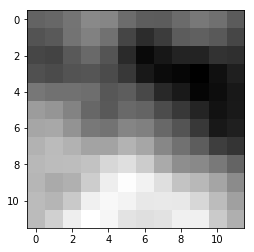

10.440844148397446

 next


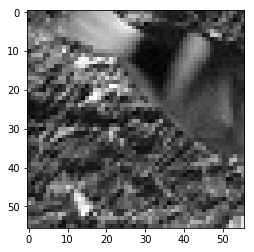

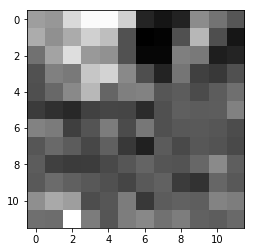

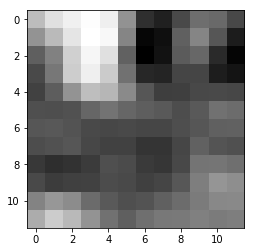

20.6916281953454

 next


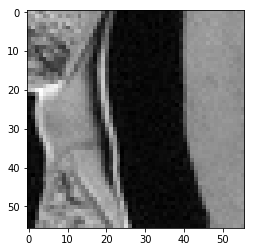

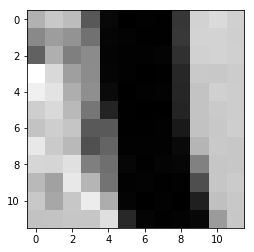

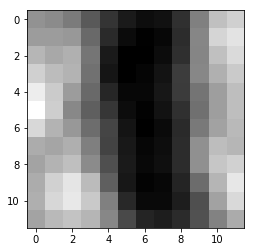

18.237060606479645

 next


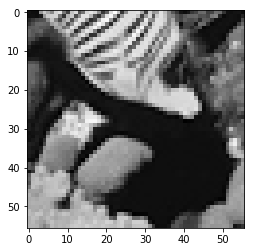

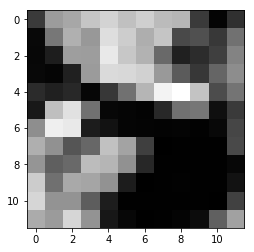

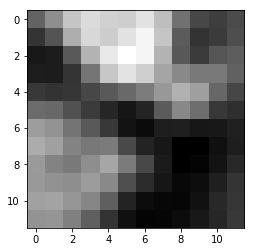

31.194057539105415

 next


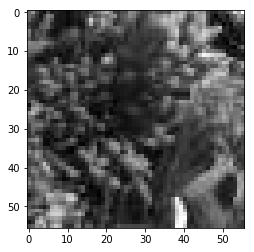

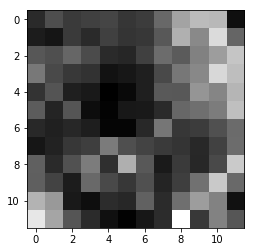

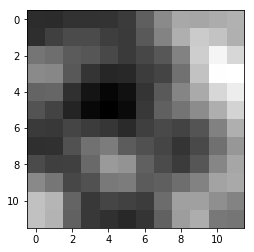

12.863656841218472

 next


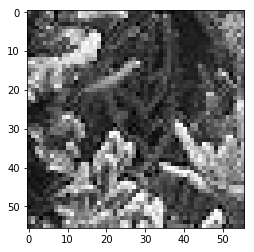

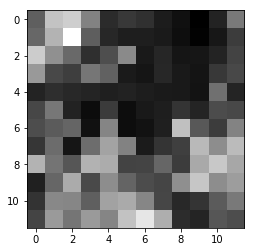

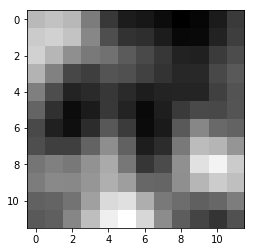

24.96440961956978

 next


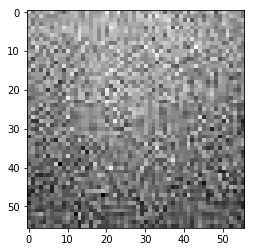

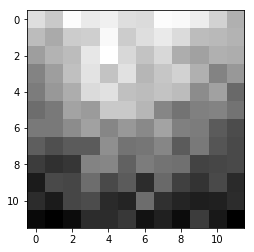

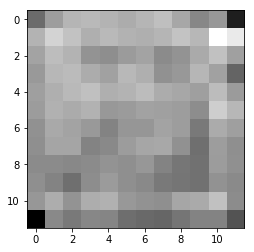

4.803385427221656

 next


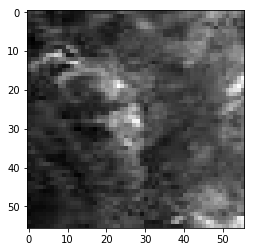

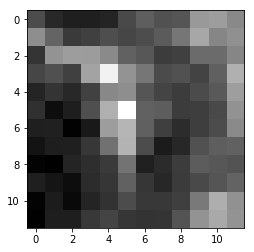

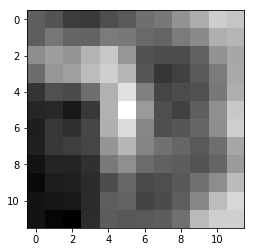

6.275824466720223

 next


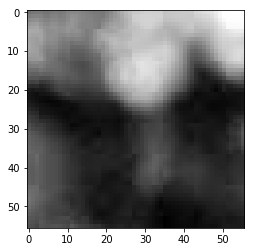

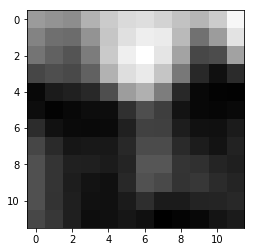

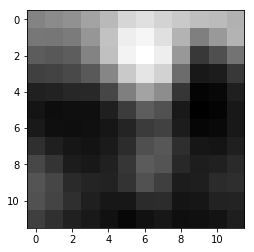

10.924654137343168

 next


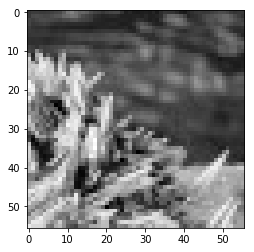

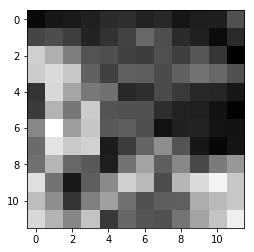

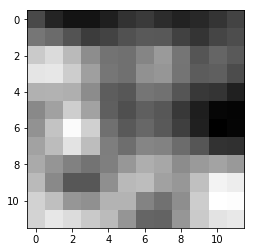

23.09280674904585

 next


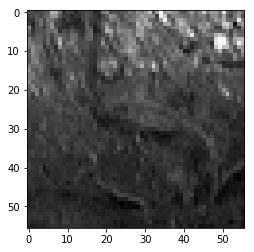

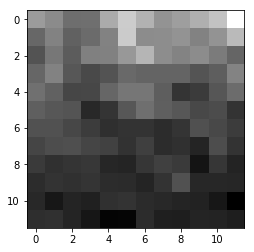

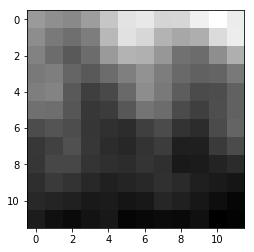

9.00957589969039

 next


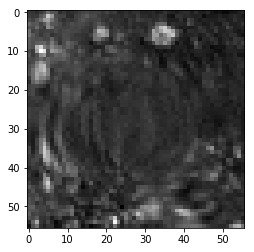

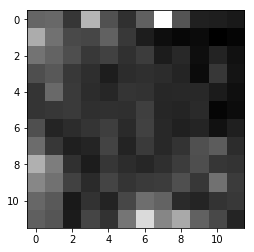

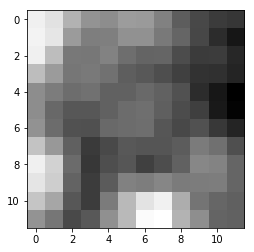

10.218123849481344

 next


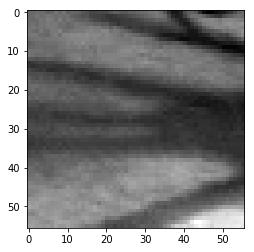

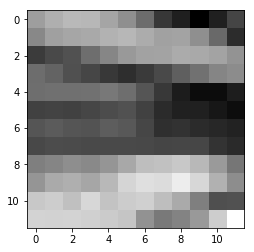

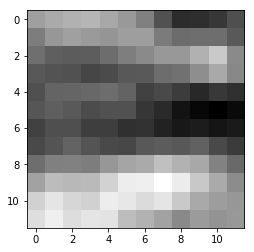

7.669329391792417

 next


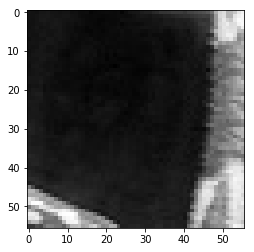

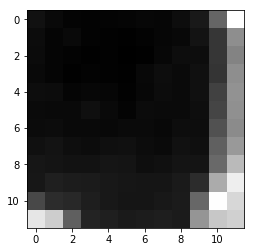

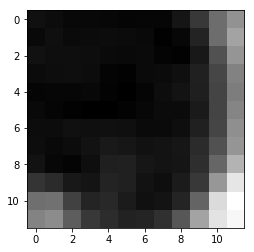

14.172865189611912

 next


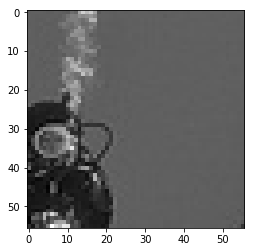

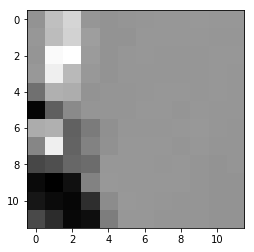

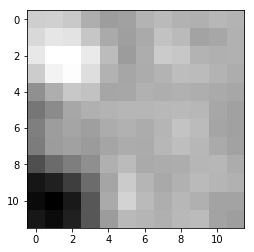

9.643143452703953

 next


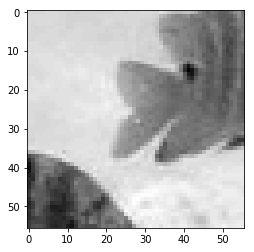

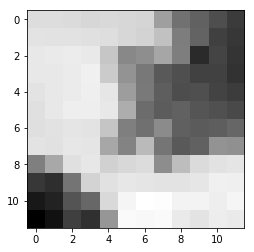

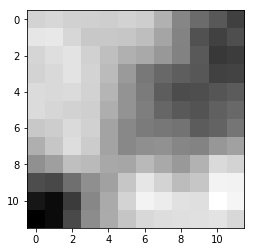

7.280482007190585

 next


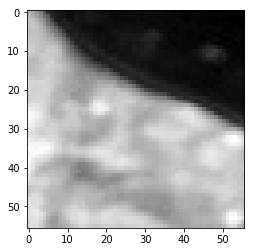

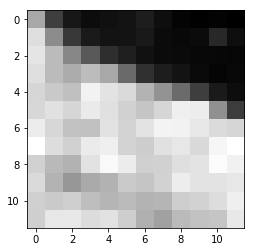

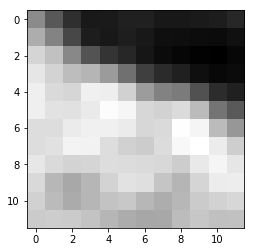

11.21196337044239

 next


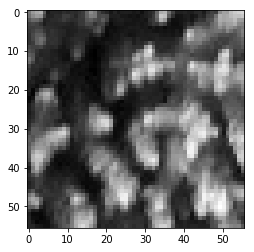

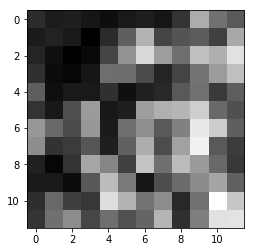

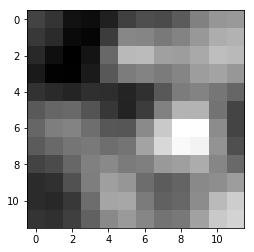

20.018384121358395

 next


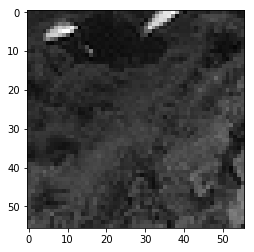

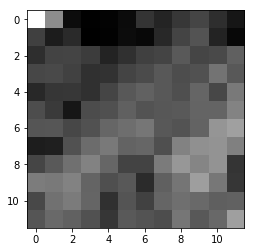

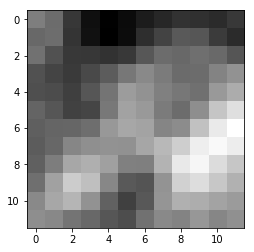

9.60790604352951

 next


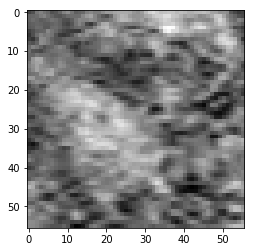

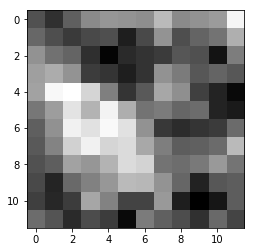

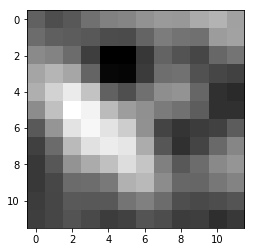

11.110002491623163

 next


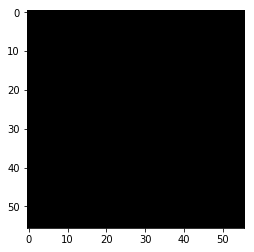

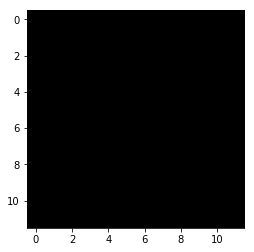

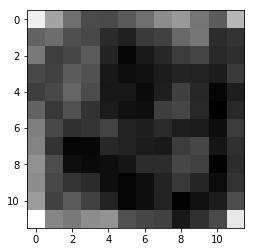

5.555391674861312

 next


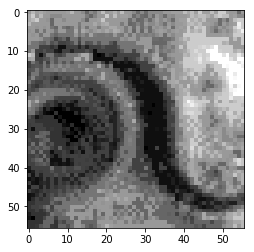

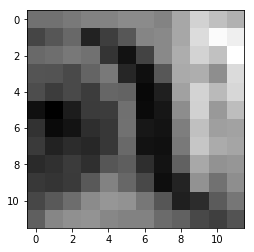

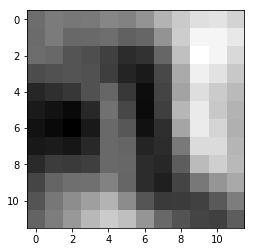

22.560909390449524

 next


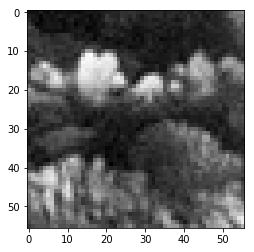

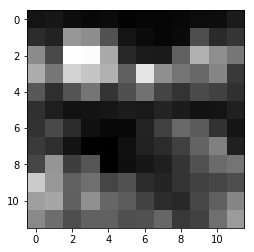

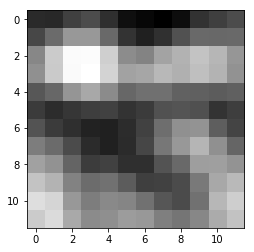

15.246693268418312

 next


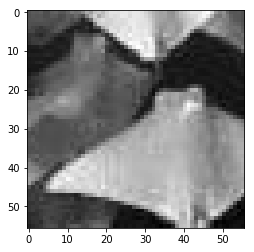

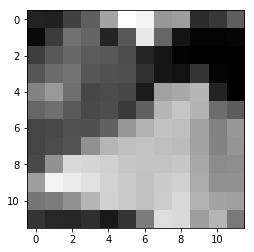

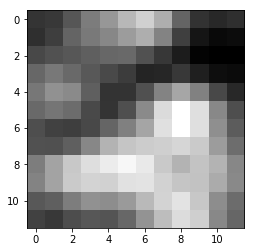

19.745024889707565

 next


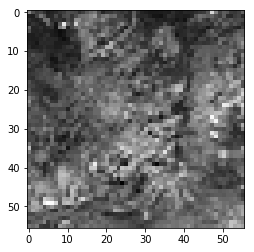

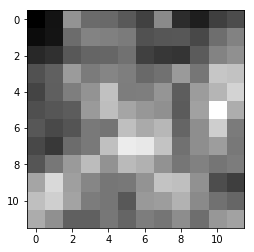

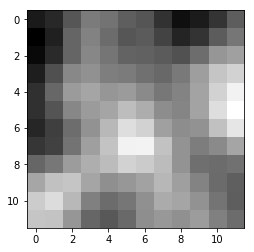

11.271540373563766

 next


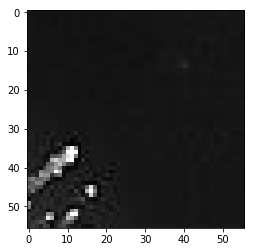

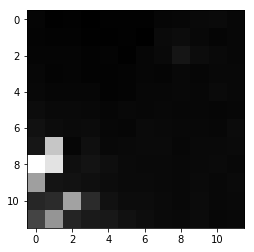

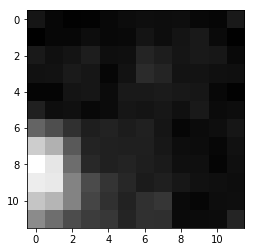

10.111009497195482

 next
0.05456736660192883


In [19]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (4, 4), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((12, 12))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)